# Problem
**Mục tiêu: Sử dụng các yếu tố sức khỏe để dự đoán một người có mắc bệnh tim hay không**

**Metric: AUC, Precision với Recall = 90 %**

Biến mục tiêu:

Có hai hướng đi:
1. Tình trạng bệnh tim với `0` là không mắc bệnh, `1` là mắc bệnh
2. Khả năng một người mắc bệnh tim (số thực mang giá trị `[0;1]`)
- **Important**: dataset của chúng ta không có sẵn biến mục tiêu dạng này, biến gần nhất là tình trạng bệnh tim nhận giá trị `0` hoặc `1`
- Đầu ra của mô hình phải phù hợp với các tính toán được y học chấp nhận

Thông qua phân tích sơ bộ, tỷ lệ mắc bệnh chung vào khoảng `8.6%`, để đầu ra thực sự có ích, thì với recall `90%` tôi mong muốn có thể có Precision tối thiểu `18%`, và với recall `95%`, precision `14%`.

Các biến dự đoán: vì đây là một vấn đề cần phân tích kỹ hơn, nên tôi sẽ thực hiện file `preprocessing.ipynb` trước khi đưa ra những nhận định về các biến dự đoán.

Tuy chúng ta không thể tự mình tìm kiếm thêm các thông tin về yếu tố sức khỏe, nhưng việc xem xét thêm các yếu tố nằm ngoài bộ dataset được chứng minh bằng các nghiên cứu y học có thể giúp ích cho việc cải tiến mô hình sau này. Vì thế, hãy xem qua một số nguồn:
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7210118/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7871691/



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data

In [2]:
df_origin = pd.read_csv('data/relevant_features.csv', index_col=0)
print(df_origin.shape)
df_origin.head()

(319795, 17)


,AgeCategory,Race,GenHealth,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,Diabetic,PhysicalActivity,KidneyDisease,SkinCancer,BMI,PhysicalHealth,MentalHealth,SleepTime
0,7,5,3,0,1,0,0,0,0,3,1,0,1,16.60,3.0,30.0,5.0
1,12,5,3,0,0,0,1,0,0,0,1,0,0,20.34,0.0,0.0,7.0
2,9,5,1,0,1,0,0,0,1,3,1,0,0,26.58,20.0,30.0,8.0
3,11,5,2,0,0,0,0,0,0,0,0,0,1,24.21,0.0,0.0,6.0
4,4,5,3,0,0,0,0,1,0,0,1,0,0,23.71,28.0,0.0,8.0


# Split train test sets

In [3]:
X = df_origin.drop('HeartDisease', axis=1)
y = df_origin['HeartDisease']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
print('Train set:\n',y_train.value_counts()/y_train.size, sep='')
print('Size of train set:', y_train.size)
print('Test set:\n',y_test.value_counts()/y_test.size, sep='')
print('Size of test set:', y_test.size)

Train set:
0    0.914753
1    0.085247
Name: HeartDisease, dtype: float64
Size of train set: 223856
Test set:
0    0.913591
1    0.086409
Name: HeartDisease, dtype: float64
Size of test set: 95939


# Data preprocessing and transforming

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Build, evaluate models, error analysis

## Import some important modules

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay

import matplotlib.pyplot as plt

## Define evaluate function

Ở đây tôi sẽ tạo ra một function thực hiện việc in ra AUC, precisions, recalls, f1 scores (sklearn's classification report) ứng với recall 90% và 95%. Ngoài ra, function sẽ hiển thị roc curve và hình ảnh trực quan xác suất bị bệnh tính toán của mô hình cho từng phần tử

In [31]:
import matplotlib.colors as mpc
import matplotlib.patches as mpatches

def find_thres(tpr: np.ndarray, fpr: np.ndarray, thres: np.ndarray, recall = 0.9):
    idx = tpr.searchsorted(recall)
    return idx, tpr[idx], fpr[idx], thres[idx]


def evaluate(model, X, y, recalls = [0.9, 0.95], name = None):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)

    # predict probability
    prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, prob)
    prob_df = pd.DataFrame({'prob': prob, 'class': y})

    # auc
    auc_score = roc_auc_score(y, prob)
    print('AUC score =', auc_score)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    roc_plot.plot(ax=ax)
    if name:
        plt.title(name)
    target_thres = {}
    precisions = {}

    # precision for each recall scores
    try:
        for recall in recalls:
            _, _, _, thres = find_thres(tpr, fpr, thresholds, recall)
            target_thres[recall] = thres
            print('Recall =', recall)
            # print(classification_report(y, prob > thres))
            conf_matrix = confusion_matrix(y, prob > thres)
            precisions[recall] = conf_matrix[-1,-1]/np.sum(conf_matrix[:,-1])
            print('Precision =',precisions[recall])
    except TypeError as e:
        print(e)
    
    # Visualize
    prob_df.sort_values('prob', inplace=True, ignore_index=True)
    plt.subplot(1,2,2)
    sc = plt.scatter(x=prob_df.index, y=prob_df['prob'].values, c=prob_df['class'].values)
    hd_color = mpc.to_hex(sc.to_rgba(1))
    no_hd_color = mpc.to_hex(sc.to_rgba(0))
    hd_patch = mpatches.Patch(color=hd_color, label='Heart disease')
    no_hd_patch = mpatches.Patch(color=no_hd_color, label='Without heart disease')
    plt.ylabel('Probability')
    plt.legend(handles = [hd_patch, no_hd_patch])
    return auc_score, target_thres, precisions

## Metrics

In [10]:
auc_scores = {}
precisions = {}

## Models

In [11]:
models = {}

### Logistic Regression

In [12]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

/home/dnj/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

Recall = 0.9
Precision = 0.1724799389380442
Recall = 0.95
Precision = 0.14224286745550987


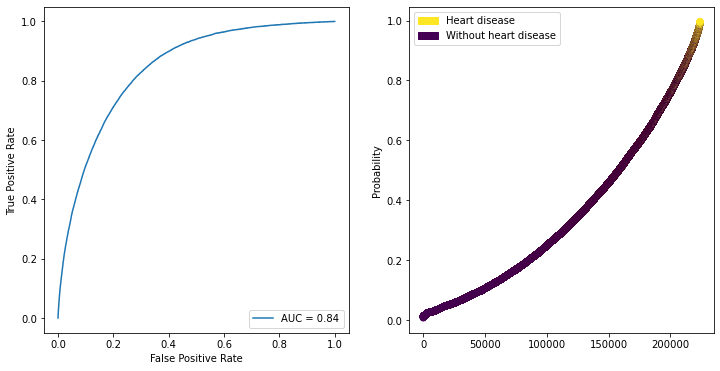

In [13]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

Recall = 0.9
Precision = 0.17014482837267647
Recall = 0.95
Precision = 0.14174376327441593


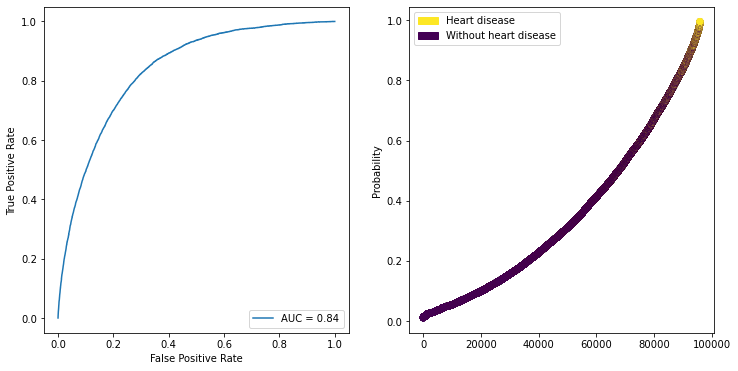

In [15]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['LR'] = model
auc_scores['LR'] = auc_score
precisions['LR'] = precision

### SVM

In [44]:
model = SVC(class_weight='balanced', probability=True)
model.fit(X_test, y_test)

In [ ]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

In [ ]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['svm'] = model
auc_scores['svm'] = auc_score
precisions['svm'] = precision

### SGD

In [21]:
model = SGDClassifier(loss='log')
model.fit(X_train, y_train)

SGDClassifier(loss='log')

Recall = 0.9
Precision = 0.16415128604608928
Recall = 0.95
Precision = 0.1365142478462558


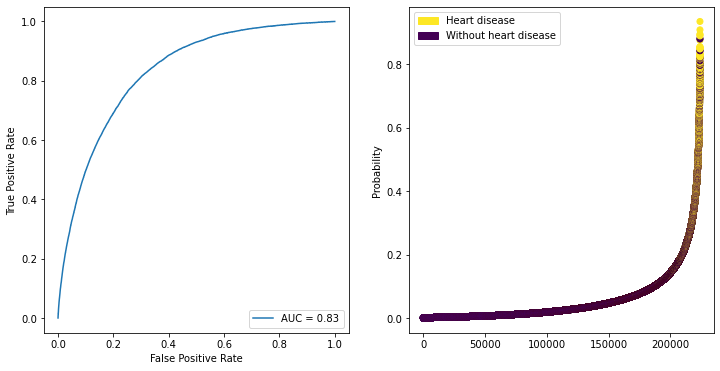

In [22]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

Recall = 0.9
Precision = 0.16327781304033795
Recall = 0.95
Precision = 0.1363919775537774


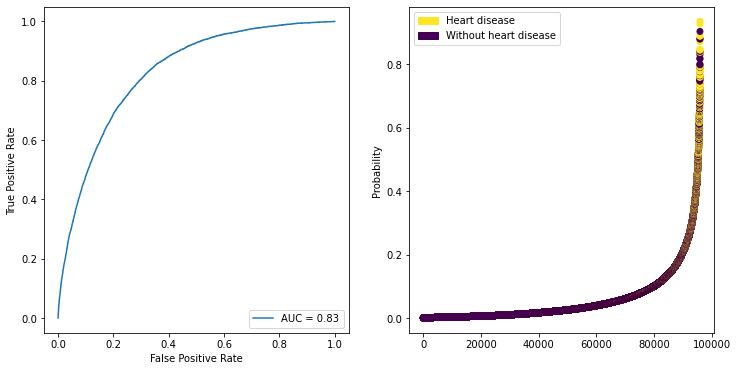

In [23]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['SGD'] = model
auc_scores['SGD'] = auc_score
precisions['SGD'] = precision

### Tree

In [23]:
model = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=300)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=300)

Recall = 0.9
Precision = 0.1772123163282153
Recall = 0.95
Precision = 0.1501727695329008


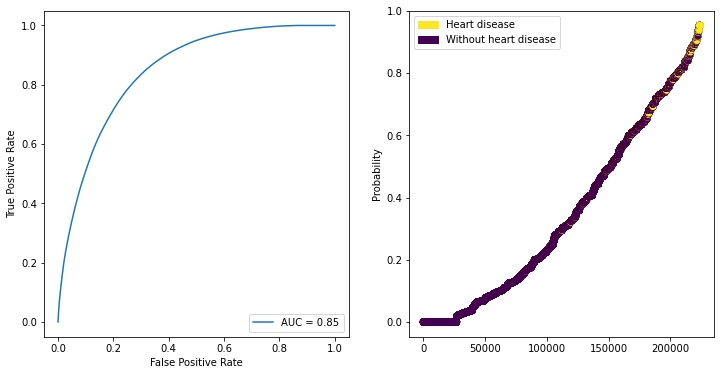

In [24]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

Recall = 0.9
Precision = 0.16502555705529617
Recall = 0.95
Precision = 0.1369107670899287


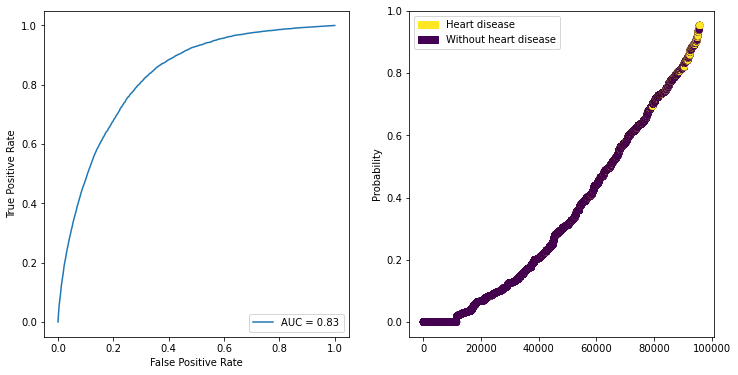

In [25]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['tree'] = model
auc_scores['tree'] = auc_score
precisions['tree'] = precision

### Gaussian

In [26]:
X_gpc_train = X_train.sample(2000)
y_gpc_train = y_train[X_gpc_train.index]

Recall = 0.9
Precision = 0.09801216612142473
Recall = 0.95
Precision = 0.09275836886616881


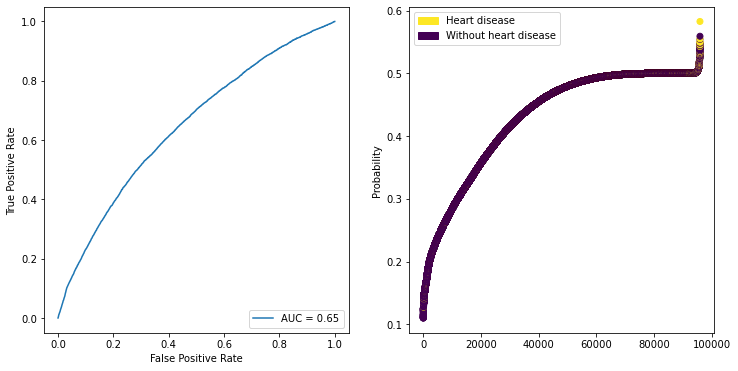

In [27]:
# GaussianProcessClassifier
# model = GaussianProcessClassifier()
# model.fit(X_gpc_train, y_gpc_train)

# auc_score, target_thres, precision = evaluate(model, X_train, y_train)

# auc_score, target_thres, precision = evaluate(model, X_test, y_test)
# models['GPC'] = model
# auc_scores['GPC'] = auc_score
# precisions['GPC'] = precision

### Random forest

In [36]:
model = RandomForestClassifier(min_samples_leaf=200)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=200)

AUC score = 0.8501653531833848
Recall = 0.9
Precision = 0.17836260346671928
Recall = 0.95
Precision = 0.14909733930994779


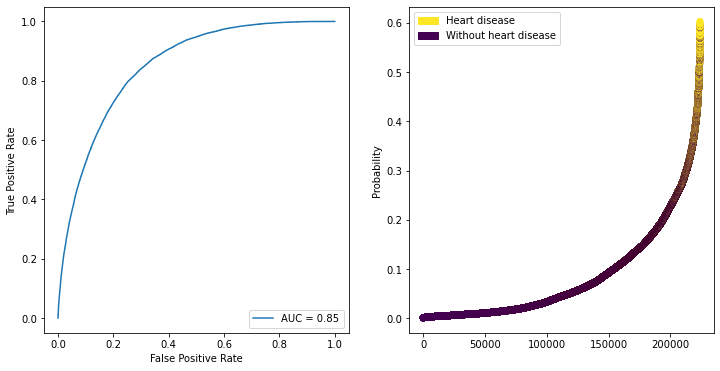

In [37]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

AUC score = 0.8381303154273047
Recall = 0.9
Precision = 0.17411193576996686
Recall = 0.95
Precision = 0.1415297796628446


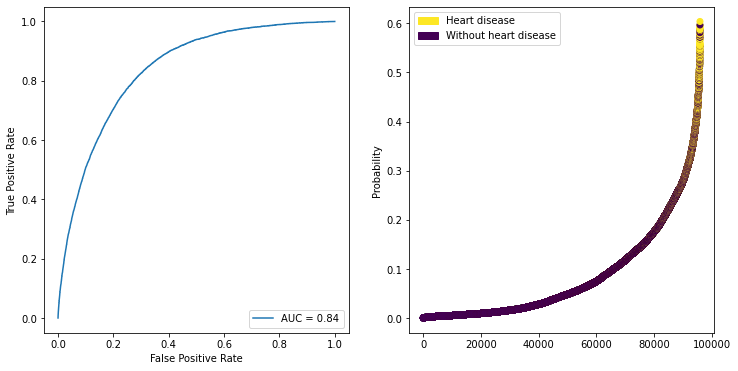

In [38]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['forest'] = model
auc_scores['forest'] = auc_score
precisions['forest'] = precision

### Naive Bayes

In [41]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

AUC score = 0.8088647269726097
Recall = 0.9
Precision = 0.15678577297376253
Recall = 0.95
Precision = 0.13202723862932886


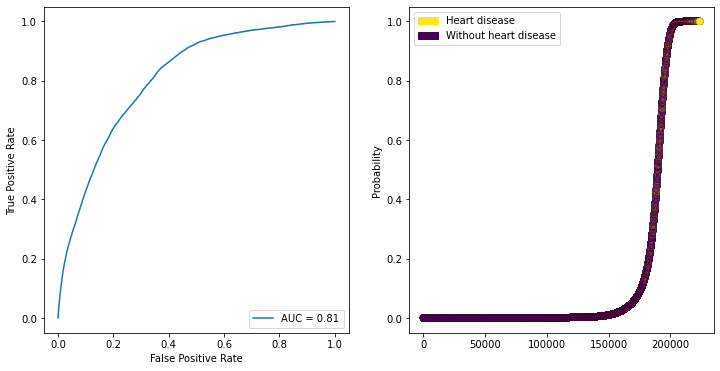

In [42]:
auc_score, target_thres, precision = evaluate(model, X_train, y_train)

AUC score = 0.804077457843594
Recall = 0.9
Precision = 0.156808340690293
Recall = 0.95
Precision = 0.1296851327317041


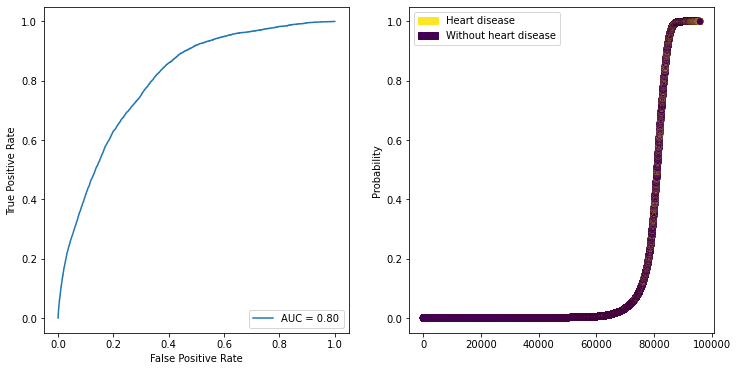

In [43]:
auc_score, target_thres, precision = evaluate(model, X_test, y_test)
models['tree'] = model
auc_scores['tree'] = auc_score
precisions['tree'] = precision

# Summary